In [1]:
import itertools
import pathlib

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import numpy as np
import seaborn as sns
sns.set(rc={'figure.figsize':(8,8)})
import sklearn.metrics
import tqdm

In [2]:
PARENT = pathlib.Path(globals()['_dh'][0]).parent
MODELS_PATH = PARENT / 'models-ner'
DATA_PATH = PARENT / 'data' / 'ner'
KEYS_TO_SUM = ['ipt', 'norm', 'mha', 'ff']

def powerset():
    yield from (
        # four singletons
        ('ipt',),
        ('mha',),
        ('ff',),
        ('norm',),
        # six duals
        ('ipt', 'mha',),
        ('ipt', 'ff',),
        ('ipt', 'norm',),
        ('mha', 'ff'),
        ('norm', 'mha',),
        ('norm', 'ff',),
        # four triplets
        ('ipt', 'mha', 'ff'),
        ('ipt', 'norm', 'mha',),
        ('ipt', 'norm', 'ff',),
        ('norm', 'mha', 'ff',),
        # one full
        ('ipt', 'norm', 'mha', 'ff',),
        
    )
    # combinations = (
    #    itertools.combinations(KEYS_TO_SUM, r)
    #    for r in range(1, len(KEYS_TO_SUM) + 1)
    #)
    #yield from itertools.chain.from_iterable(combinations)

    
class BertFactorRiterDataset(Dataset):
    """torch object for convenience"""
    def __init__(self, file_name, tokenizer_=None, model_=None):
        raise NotImplemented

    def save(self, file):
        torch.save(self, file)

    @staticmethod
    def load(file):
        return torch.load(file)

    def __getitem__(self, idx):
        self.items[idx]['tgt_idx'] = self.tag_stoi[self.items[idx]['tag']]
        return self.items[idx]

    def __len__(self):
        return len(self.items)


In [3]:
@torch.no_grad()
def eval_model(keys_to_sum, model_subdir, dataset):
    model_name = ("_".join(keys_to_sum) + ".pt")
    ner_model = torch.load(model_subdir / model_name, map_location='cpu')
    pbar = tqdm.notebook.tqdm(dataset, desc="Test", leave=False, disable=None)
    all_true = []
    all_preds = []
    ner_model.eval()
    running_loss, total_items = 0, 0
    total_acc = 0
    for batch in pbar:
        all_ipts = sum(batch[key].to('cpu') for key in keys_to_sum)
        mlp_output = ner_model(all_ipts)
        tgt = batch['tgt_idx'].view(-1).to('cpu')
        loss = F.cross_entropy(mlp_output, tgt, reduction='sum')
        all_preds.extend(mlp_output.argmax(-1).view(-1).tolist())
        all_true.extend(tgt.tolist())
        acc = (F.softmax(mlp_output, dim=-1).argmax(dim=-1) == tgt).sum()
        running_loss += loss.item()
        total_acc += acc.item()
        total_items += batch['tgt_idx'].numel()
        pbar.set_description(f"Test (L={running_loss/total_items:.4f}, A={total_acc/total_items:.4f})")
    new_f1 = sklearn.metrics.f1_score(all_true, all_preds, average='macro')
    #print(model_subdir, model_name, new_f1)
    return new_f1

In [4]:
def get_best_models(path_to_models, path_to_data, untuned=True):
    subdir = ('untuned' if untuned else 'tuned')
    path_to_test_set = path_to_data / subdir / 'test.pt'
    dataset = DataLoader(BertFactorRiterDataset.load(path_to_test_set), shuffle=False, batch_size=512)
    all_results = []
    for run in range(1, 6):
        all_results.append([])
        for keys in powerset():
            model_subdir = path_to_models / f'{subdir}-{run}'
            f1 = eval_model(keys, model_subdir, dataset)
            all_results[-1].append(f1)
    return all_results
    
all_wsd_f1 = np.array(get_best_models(MODELS_PATH, DATA_PATH))* 100

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

In [5]:
grad_cmds = ["\\" + f'grad{chr(c)}' for c in range(ord('A'), ord('O')+1)]
def get_ranks(run):
    ranks = np.empty_like(run)
    ranks[run.argsort()] = np.arange(run.shape[0])
    return ranks

shades  = np.array([get_ranks(run) for run in all_wsd_f1]).astype(int)
best_run = all_wsd_f1.argmax(0)
individual_cells = [[] for _ in range(5)]
for key_idx in range(all_wsd_f1.shape[1]):
    for run_idx in range(all_wsd_f1.shape[0]):
        grad_cmd = grad_cmds[shades[run_idx,key_idx]]
        score = str(all_wsd_f1[run_idx,key_idx]) 
        if best_run[key_idx] == run_idx:
            cell_value = "{" + grad_cmd + "\\bestCell{" + score + "}}"
        else:
            cell_value = "{" + grad_cmd + "} " + score
        individual_cells[run_idx].append(cell_value)
print(*[" &&\n" + " & ".join(single_run) +"\n\\\\" for single_run in individual_cells ], sep="\n")

 &&
{\gradC} 14.925487293085993 & {\gradK} 32.89274940603739 & {\gradF} 31.11541102910062 & {\gradA} 4.924466891933662 & {\gradD} 20.954431035502612 & {\gradE} 30.623264378747727 & {\gradB} 12.806387109056699 & {\gradH} 31.768447168677316 & {\gradO\bestCell{34.62474424197677}} & {\gradI\bestCell{32.42514452066802}} & {\gradN} 34.0286710283412 & {\gradJ} 32.52460058284885 & {\gradG} 31.44503037906211 & {\gradM} 33.8473243861131 & {\gradL} 32.947501604670684
\\
 &&
{\gradC\bestCell{15.790921559066351}} & {\gradM\bestCell{34.156410085837294}} & {\gradG} 31.05029159515828 & {\gradA} 4.8796685520470815 & {\gradO\bestCell{34.384148690759126}} & {\gradH} 31.07969823890693 & {\gradB} 10.261161846763434 & {\gradN} 34.308950588092124 & {\gradK} 33.12237671365441 & {\gradD} 30.13882118146335 & {\gradI} 31.844803043188307 & {\gradJ} 32.57258354841511 & {\gradE} 30.48107932510228 & {\gradL\bestCell{33.99345960747829}} & {\gradF} 30.819491947859873
\\
 &&
{\gradC} 15.458678510110394 & {\gradF} 29.94

In [6]:
means = all_wsd_f1.mean(0)
shades = get_ranks(means).astype(int)
single_run = []
for key_idx in range(all_wsd_f1.shape[1]):
    grad_cmd = grad_cmds[shades[key_idx]]
    score = str(means[key_idx]) 
    cell_value = "{" + grad_cmd + "} " + score
    single_run.append(cell_value)
print(" & ".join(single_run), sep="\n")


print(" & ".join("{{$\pm$\\numprint{" + s + "}}}" for s in  all_wsd_f1.std(0).astype(str)))

{\gradC} 13.24911548118823 & {\gradM} 32.91344747190871 & {\gradH} 30.764215062532024 & {\gradA} 5.065460476851208 & {\gradF} 30.0897854492068 & {\gradG} 30.44418255313313 & {\gradB} 12.374017892134797 & {\gradL} 32.773912781507214 & {\gradO} 33.399183224310704 & {\gradD} 28.290017551935808 & {\gradK} 32.70887660750459 & {\gradN} 33.25409736134693 & {\gradI} 31.755779722562135 & {\gradE} 29.20224245661682 & {\gradJ} 32.30362423043927
{{$\pm$\numprint{4.373384721255649}}} & {{$\pm$\numprint{1.5461578579596194}}} & {{$\pm$\numprint{0.9308152766480522}}} & {{$\pm$\numprint{0.19503971057095618}}} & {{$\pm$\numprint{5.060599238389999}}} & {{$\pm$\numprint{1.3374301254239922}}} & {{$\pm$\numprint{1.1621263505427342}}} & {{$\pm$\numprint{1.2673323601975217}}} & {{$\pm$\numprint{0.7942707588895789}}} & {{$\pm$\numprint{5.525657952347001}}} & {{$\pm$\numprint{1.3771827962646972}}} & {{$\pm$\numprint{0.7580017498076391}}} & {{$\pm$\numprint{0.856923906286014}}} & {{$\pm$\numprint{7.8301936733421

In [7]:
all_wsd_f1_tuned = np.array(get_best_models(MODELS_PATH, DATA_PATH, untuned=False))* 100

shades_tuned  = np.array([get_ranks(run) for run in all_wsd_f1_tuned]).astype(int)
best_run_tuned = all_wsd_f1_tuned.argmax(0)
individual_cells_tuned = [[] for _ in range(5)]
for key_idx in range(all_wsd_f1.shape[1]):
    for run_idx in range(all_wsd_f1_tuned.shape[0]):
        grad_cmd = grad_cmds[shades_tuned[run_idx,key_idx]]
        score = str(all_wsd_f1_tuned[run_idx,key_idx]) 
        if best_run_tuned[key_idx] == run_idx:
            cell_value = "{" + grad_cmd + "\\bestCell{" + score + "}}"
        else:
            cell_value = "{" + grad_cmd + "} " + score
        individual_cells_tuned[run_idx].append(cell_value)
print(*[" &&\n" + " & ".join(single_run) +"\n\\\\" for single_run in individual_cells_tuned], sep="\n")
print("\n" *3)
means_tuned = all_wsd_f1_tuned.mean(0)
shades_tuned = get_ranks(means_tuned).astype(int)
single_run_tuned = []
for key_idx in range(all_wsd_f1.shape[1]):
    grad_cmd = grad_cmds[shades_tuned[key_idx]]
    score = str(means_tuned[key_idx]) 
    cell_value = "{" + grad_cmd + "} " + score
    single_run_tuned.append(cell_value)
print(" & ".join(single_run_tuned), sep="\n")
print("\n" *3)
print(" & ".join("{{$\pm$\\numprint{" + s + "}}}" for s in  all_wsd_f1_tuned.std(0).astype(str)))

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

Test:   0%|          | 0/121 [00:00<?, ?it/s]

 &&
{\gradC\bestCell{16.27753618335451}} & {\gradM} 39.23859083686958 & {\gradD} 36.962535752528076 & {\gradA} 12.229267478987357 & {\gradN\bestCell{39.922041727698556}} & {\gradI} 38.65491696901654 & {\gradB} 15.698953548896993 & {\gradF} 37.39018182789866 & {\gradK} 38.673786447637944 & {\gradH} 38.2483696626909 & {\gradJ} 38.669882762078565 & {\gradO\bestCell{40.173118405709715}} & {\gradL} 39.00585098563675 & {\gradE} 37.29527147504887 & {\gradG} 37.45978676674074
\\
 &&
{\gradA} 5.065561627975216 & {\gradO} 39.62258914360729 & {\gradK} 38.80035528309326 & {\gradC} 8.689602400372053 & {\gradH} 38.58216490006029 & {\gradN\bestCell{39.496565904296304}} & {\gradB} 6.356744201261226 & {\gradE} 37.673636551208176 & {\gradL} 38.86235118804534 & {\gradF} 37.851658262985914 & {\gradJ} 38.767700508415324 & {\gradG} 38.01439853098153 & {\gradM} 39.30704365540667 & {\gradD} 37.65002298830424 & {\gradI} 38.59927839956613
\\
 &&
{\gradC} 16.062039281524264 & {\gradK} 39.05720218355015 & {\gradI

In [8]:

DEVICE = 'cpu'

@torch.no_grad()
def best_preds_to_matrix(filename, untuned=True):
    subdir = ('untuned' if untuned else 'tuned')
    best_runs_considered = best_run if untuned else best_run_tuned
    path_to_test_set = DATA_PATH / subdir / 'test.pt'
    dataset = DataLoader(BertFactorRiterDataset.load(path_to_test_set), shuffle=False, batch_size=512)
    all_preds = {}
    for run, keys_to_sum in zip(best_runs_considered.tolist(), powerset()):
        run += 1
        all_preds[keys_to_sum] = []
        ner_model = torch.load(MODELS_PATH / f'{subdir}-{run}' / ("_".join(keys_to_sum) + '.pt'), map_location=torch.device(DEVICE))
        pbar = tqdm.tqdm(dataset, desc="Test", leave=False, disable=None)
        ner_model.eval()
        running_loss, total_items = 0, 0
        total_acc = 0
        with torch.no_grad():
            all_true = []
            for batch in pbar:
                all_ipts = sum(batch[key].to(DEVICE) for key in keys_to_sum)
                mlp_output = ner_model(all_ipts)
                tgt = batch['tgt_idx'].view(-1).to(DEVICE)
                loss = F.cross_entropy(mlp_output, tgt, reduction='sum')
                all_preds[keys_to_sum].extend(mlp_output.argmax(-1).view(-1).tolist())
                all_true.extend(tgt.tolist())
                acc = (F.softmax(mlp_output, dim=-1).argmax(dim=-1) == tgt).sum()
                running_loss += loss.item()
                total_acc += acc.item()
                total_items += batch['tgt_idx'].numel()
                pbar.set_description(f"Valid (L={running_loss/total_items:.4f}, A={total_acc/total_items:.4f})")
    matrix_view = np.zeros((len(all_preds), len(all_preds)))
    for i, keys_1 in enumerate(powerset()):
        for j, keys_2 in enumerate(powerset()):
            matrix_view[i, j] = sklearn.metrics.f1_score(all_preds[keys_1], all_preds[keys_2], average='micro')
    # print(matrix_view.tolist())
    np.save(filename, matrix_view)

 

In [9]:
best_preds_to_matrix('../data/f1-classif-ritter-tuned-allbest.npy', untuned=False)
best_preds_to_matrix('../data/f1-classif-ritter-untuned-allbest.npy', untuned=True)

In [10]:
def matrix_to_heatmap(matrix_dump): # 'f1-classif-semcor.npy'

    data = np.load(matrix_dump)
    mask = np.triu(data)
    data = data[1:,:-1]
    mask = mask[1:,:-1]

    keys_in_order = [
        ('I',), ('H',), ('F',), ('C',),
        ('I', 'H'), ('I', 'F'), ('I', 'C'), ('H', 'F'), ('H', 'C'), ('F', 'C'),
        ('I', 'H', 'F'), ('I', 'H', 'C'),  ('I', 'F', 'C'), ('H', 'F', 'C'),
        ('I', 'H', 'F', 'C')
    ]

    labels = ["+".join(l) for l in keys_in_order]

    sns.heatmap(data, vmin=0, vmax=1, annot=True, square=True, xticklabels=labels[:-1], yticklabels=labels[1:], cmap="flare", mask=mask, cbar=False)

In [11]:
#matrix_to_heatmap('../data/f1-classif-semcor.npy')

In [12]:
#matrix_to_heatmap('../data/f1-knn5-semcor.npy')

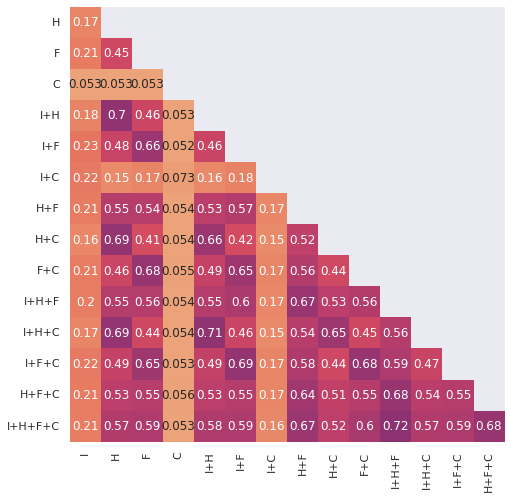

In [13]:
matrix_to_heatmap('../data/f1-classif-ritter-untuned-allbest.npy')

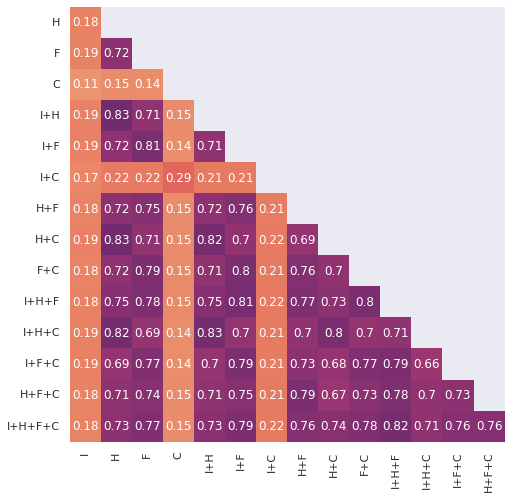

In [14]:
matrix_to_heatmap('../data/f1-classif-ritter-tuned-allbest.npy')